# MNIST Next-Number Image Mapping with a Densely Connected NN (HuggingFace Accelerate)

Most of this notebook is identical to the one describing the workflow for base PyTorch. Anything you need to do differently will be <span style="color: red;">noted in red.</span>. An "accelerator" is a device which is not the GPU that is used for speeding up (i.e. accelerating) training. So HuggingFace Accelerator is designed to interface with these accelerating devices and make your workflow more streamlined. Accelerate encapsulates data transfer to the GPU as well as multi-GPU support.

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from netCDF4 import Dataset as nc_Dataset
from torch.utils.data import DataLoader

from tqdm import tqdm
import xarray as xr
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from accelerate import Accelerator, notebook_launcher

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Boilerplate Classes
Every workflow using base PyTorch must have, at minimum, the following two classes implemented.
### Dataset Class
Inherits from torch.utils.data.Dataset, an abstract class (so no super().\_\_init\_\_() needed in constructor). This class encapsulates opening your dataset and extracting samples. When instantiated, this class can be indexed like a list. It must implement the following three methods:
- **\_\_init\_\_(self, \*args)** : Class constructor. Either open your dataset from the filesystem and set as a class attribute or specify paths, sample indices, etc. for opening on the fly.
- **\_\_len\_\_(self, \*args)** : Defines the number of elements in your dataset. In this example, it is very simple; it's just the number of elements in our mapping CSV file. But it can become more complex with dynamically generated samples.
- **\_\_getitem\_\_(self, idx, \*args)** : Implements indexing for the class. This way, YourDatasetClass\[0\] will return a tuple of (predictors, target). Note: it is important to return a tuple of tuples in this method e.g. ( (predictors), (target) ). This allows nice tuple unpacking syntax. It also PyTorch to do numpy to tensor casting under the hood.

### Model Class
Inherits from torch.nn.Module. This class encapsulates your model architecture. 
- **\_\_init\_\_(self, \*args)** : Class constructor that calls super this time. Used to assemble all your model's components at instantiation. In general, any child class of torch.nn.Module can be nested as a compnent in another Module. This means that if you have a custom "block" (e.g. ConvNext), you can define that as its own class and then create instances in this constructor.
- **forward(self, x, \*args)** : Describes how an input tensor, x, moves through your model. Since most modules don't mutate x, x is reassigned after each operation. It goes without saying that the final tensor returned by this method should match the dimensions of your target.


In [2]:
class MNISTNextDigitDataset(Dataset):
    """
    Assumes you've generated nc files as described in create_nc_MNIST.py and have mappings from MNIST_num2num_mapping.py.
    """
    def __init__(self, is_train = False):
        """
        :param is_train: bool - describes whether to load training or testing dataset
        """

        #get paths
        package_root = os.path.dirname(os.getcwd())
        if is_train:
            data_save_path = os.path.join(package_root, "data", "MNIST", "nc_versions", "MNIST_training.nc")
            indices_save_path = os.path.join(package_root, "data", "MNIST", "num2num_indices", "train_indices.csv")
        else:
            data_save_path = os.path.join(package_root, "data", "MNIST", "nc_versions", "MNIST_testing.nc")
            indices_save_path = os.path.join(package_root, "data", "MNIST", "num2num_indices", "test_indices.csv")

        #open netCDF4 Dataset of MNIST
        self.nc_dataset = nc_Dataset(data_save_path)

        #read mapping indices from CSV
        self.predictor_indices, self.target_indices = self._read_mapping_indices_from_csv(indices_save_path)
        assert len(self.predictor_indices) == len(self.target_indices), "Predictor indices array should be of the same length as the target indices array"
        
    def __len__(self):
        return len(self.predictor_indices)
        
    def __getitem__(self, idx):

        #get sample index for predictor and target
        p_idx = self.predictor_indices[idx]
        t_idx = self.target_indices[idx]

        #extract images from nc_dataset
        predictor = self.nc_dataset["image"][p_idx,:,:].data[np.newaxis,:,:] #get image and add channel dimension
        target = self.nc_dataset["image"][t_idx,:,:].data[np.newaxis,:,:]
        
        return (predictor), (target) #important to return tuple of tuples! Allows nice X, y unpacking and allows PyTorch to do the tensor casting itself
    
    @staticmethod
    def _read_mapping_indices_from_csv(csv_path):
        df = pd.read_csv(csv_path)
        predictor_indices = df['predictor'].values 
        target_indices = df['target'].values
        return predictor_indices, target_indices

#super simple neural net
class DenseNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        #define components of your network
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), #hidden layer 1; img_dim -> 512 neurons
            nn.ReLU(), #activation
            nn.Linear(512,512), #hidden layer 2; 512 neurons -> 512 neurons
            nn.ReLU(), #activation
            nn.Linear(512, 28*28), #output layer; 512 neurons -> img_dim
        )

    def forward(self, x):
        x = self.flatten(x) #flatten the image into a very long 1D vector
        x = self.linear_relu_stack(x) #pass it through the two hidden layers
        x = x.view(-1, 1, 28, 28) #reshape the final 1D vector back into an image
        return x

## Instantiating Training Objects

To prepare for the training loop, we must instantiate all the objects that will be used. This includes the model, and architecture hyperparameters can be passed as arguments to the constructor; the loss function (MSE loss in this case); the optimizer; the datasets; and dataloaders.

A quick note on data loaders: torch.utils.data.DataLoader wraps your dataset to accomodate batching and shuffling of data. They can also cause unexpected behavior like returning a list instead of a tuple.

<span style="color: red; text-decoration: line-through;">Another quick note: if you are training on your GPU, you must put your model onto that device with model.to(device)</span>

<span style="color: red;">In addition to the usual objects for training, we also need to instantiate the Accelerator object. For information on all of the kwargs that can be supplied, see [the documentation](https://huggingface.co/docs/accelerate/main/en/package_reference/accelerator#accelerator). Once we have the accelerate object, we must wrap all other training objects with accelerator.prepare(*args) so that they can be managed with the Accelerate library.</span>

In [3]:
#PyTorch's lingo for your GPU
device = ("cuda")

#initialize model and put it on the GPU
model = DenseNeuralNetwork()

#set training hyperparameters
model_name = "dense_nn_2HL_Accelerate"
learning_rate = 1e-3
batch_size = 64
epochs = 5
num_dataloader_workers = 2 # Number of separate processes to load data during training (2-8 usually sufficient)
precision = "fp16" #always use float 16. Helps with speed and GPU memory

#initialize optimization objects
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

#load datasets
train_ds = MNISTNextDigitDataset(is_train = True)
test_ds = MNISTNextDigitDataset(is_train = False)

#put datasets into DataLoaders so PyTorch handles batches and shuffling
train_dataloader = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_ds, batch_size = batch_size, shuffle = True)

#create HuggingFace Accelerator object
accelerator = Accelerator(mixed_precision = precision)

#wrap training components
train_dataloader, test_dataloader, model, optimizer = accelerator.prepare(train_dataloader, test_dataloader, model, optimizer)

## Model Performance Prior to Training
Let's take a look at what a model initialized with random weights predicts. The first cell gives the average MSE over the test dataset. The second cell visualizes a random test sample.

In [4]:
def evaluate_model(model, loss_function, test_dataloader):
    """
    Prints the average value of your model's loss on the test dataset
    :param model: torch.nn.Module - your model you're training
    :param loss_function: torch.nn.Module - your loss function
    :param test_dataloader: torch.utils.data.DataLoader - Your test dataset's data loader
    """
    model.eval()
    test_loss = 0.
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_function(pred, y).item()
    print(f"Avg test loss: {test_loss / len(test_dataloader)}")

#see how a randomly initialized model performs
print("Performance before training:")
evaluate_model(model, loss_function, test_dataloader) #not very useful to us at this point...

Performance before training:
Avg test loss: 0.1154534819598396


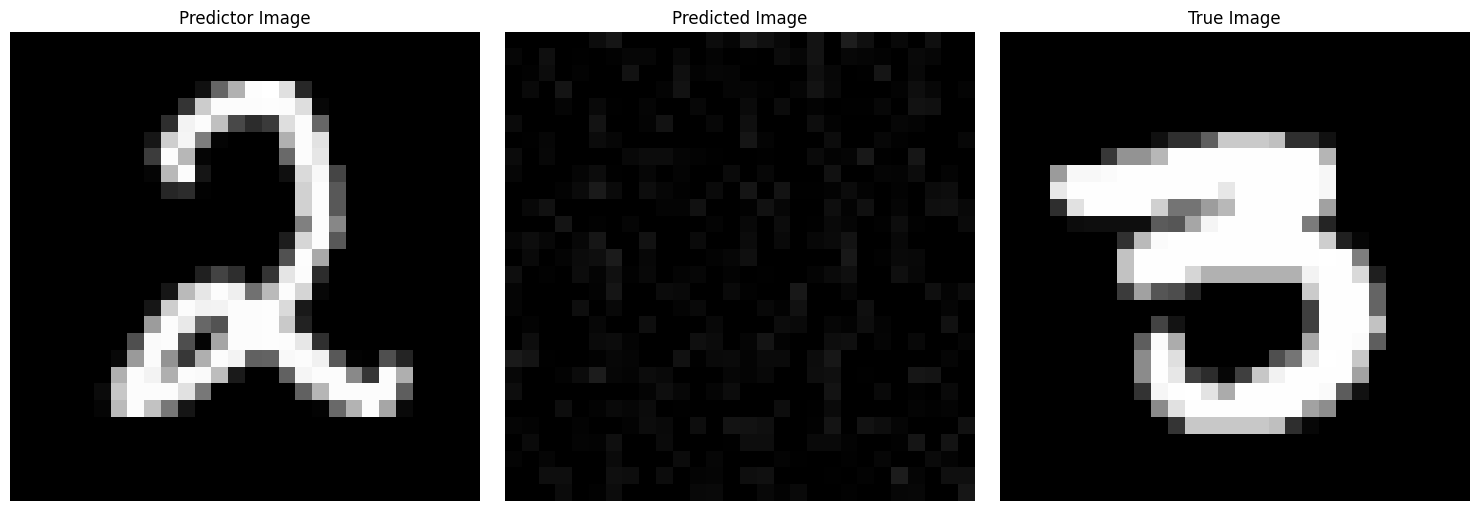

In [5]:
def plot_num2num_prediction(X, y, pred):
    """
    X, y, and pred are all numpy arrays of dimension (28, 28)
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(X.squeeze(), cmap="gray", vmin = 0., vmax = 1.)
    axes[0].set_title(f"Predictor Image")
    axes[0].axis("off")
    axes[1].imshow(pred.squeeze(), cmap="gray", vmin = 0., vmax = 1.)
    axes[1].set_title(f"Predicted Image")
    axes[1].axis("off")
    axes[2].imshow(y.squeeze(), cmap="gray", vmin = 0., vmax = 1.)
    axes[2].set_title(f"True Image")
    axes[2].axis("off")
    plt.tight_layout()
    plt.show()

#select a random sample from our test dataset
rand_test_idx = np.random.randint(len(test_ds))
i = rand_test_idx

#index test Dataset to get predictor (X) and target (y)
X, y = test_ds[i]
X_gpu = torch.from_numpy(X).to(device) #put the data onto the gpu

#make a prediction without keeping track of the gradient
with torch.no_grad():
    pred = model(X_gpu)
    pred = pred.cpu().numpy()

#plot predictions
plot_num2num_prediction(X, y, pred) #ok, there's room for improvement!

## The Training Loop
In base PyTorch, the training loop describes what should be done for each epoch of model training. For each epoch, you should do the following:
- set model.train() (as opposed to model.eval()). This enables bells and whistles like Dropout and BatchNorm
- iterate over your training DataLoader to get training samples
- <span style="color: red"> make sure to do all gradient computations with accelerator.accumulate(model)</span>
- <span style="color: red; text-decoration: line-through;">if running on your GPU, put your predictors, X, and targets, y, onto the GPU</span>
- make predictions by calling model(X)
- compute and store loss by feeding predictions and targets to your loss function object <span style="color: red"> with Accelerator autocasting to fp16</span>

Great! Now we have all we need to perform backpropogation. To do so:
- <span style="color: red">accelerator.backward() </span> computes the gradient of all model parameters with respect to the loss function via autodifferentiation
- <span style="color: red">accelerator.sync_gradients() checks if gradients need to be synced across all processes </span>
- optimizer.step() performs its flavour of gradient descent to adjust parameters
- optimizer.zero_grad() gets rid of the computed gradient in preparation for the next epoch

Lastly, we need an evaluation on our validation or testing dataset in order to confirm we are not overfitting. I simply use average MSE as before. Additionally, I've implemented model checkpointing so after every epoch, the model -- along with all the necessary objects for training -- is saved to disk and can be loaded to resume training or perform inference across multiple epochs. <span style="color: red">The main process check is, again, just for multi-GPU training. </span>

In [6]:
def save_model_checkpoint(epoch, model, optimizer, loss, model_name = "dense_nn_2HL"):
    """
    Saves a model such that you can load it and resume training.
    :param epoch: int - the training epoch in which the model is being saved
    :param model: torch.nn.Module - your model you're training
    :param optimizer: torch.optim.Optimizer - the optimizer you're using to update nn params
    :param loss: object returned by your loss function (e.g. loss = loss_function(pred, y))
    :param model_name: str - name of the directory in which your model checkpoints will be saved
    """
    #save model for resuming training
    package_root = os.path.dirname(os.getcwd())
    model_save_dir = os.path.join(package_root, "models", "MNIST_num2num", "model_checkpoints", model_name)
    os.makedirs(model_save_dir, exist_ok = True)
    torch.save({
        "epoch" : epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss
        }, os.path.join(model_save_dir, f"epoch{epoch}.pth"))

for epoch in range(epochs):
    print(f"Starting epoch {epoch + 1}")

    #Run training loop
    model.train()
    for batchnum, data in enumerate(tqdm(train_dataloader, leave = False)):
        with accelerator.accumulate(model):

            #make predictions
            X, y = data
            pred = model(X)

            #calculate loss
            with accelerator.autocast():
                loss = loss_function(pred, y)
    
            #Backprop
            accelerator.backward(loss)
            if accelerator.sync_gradients: #included for multi-gpu training
                optimizer.step()
                optimizer.zero_grad()

    #at the end of each 
    if accelerator.is_main_process:
        evaluate_model(model, loss_function, test_dataloader)
        save_model_checkpoint(epoch, model, optimizer, loss, model_name = model_name)


Starting epoch 1


Avg test loss: 0.05539715077025822
Starting epoch 2


Avg test loss: 0.05463659933533151
Starting epoch 3


Avg test loss: 0.05471463996571855
Starting epoch 4


Avg test loss: 0.05451220099013834
Starting epoch 5


Avg test loss: 0.0545733798973667


## Saving and Loading the Final Model
Once your model is in a spot where you no longer wish to update its parameters, you can save just its state dictionary. Torch save just pickles the object. To load, create a new instance of your model class and call model.load_state_dict(PATH, weights_only = True). Then set your model to evaluation mode, put it on the right device, and you're ready for inference!

In [7]:
#save the trained model for *inference*
package_root = os.path.dirname(os.getcwd())
model_save_dir = os.path.join(package_root, "models", "MNIST_num2num")
os.makedirs(model_save_dir, exist_ok = True)
torch.save(model.state_dict(), os.path.join(model_save_dir, "dense_nn_2HL.pth"))

#load it, because we can
model = DenseNeuralNetwork()
model.load_state_dict(torch.load(os.path.join(model_save_dir, "dense_nn_2HL.pth"), weights_only = True))
model.eval()
model.to(device)

DenseNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)

## Model Performance After Training

Now when we feed the trained model a predictor image, it successfully creates an image of the next digit, abeit fuzzily. This has everything to do with the uncertainty in the problem. The digit mapping is *not* injective, that is, the same digit may be mapped to several different subsequent ones. Therefore, when asking the model to make a deterministic step to the next digit, it has to "hedge" against not knowing the particular form of the next digit.

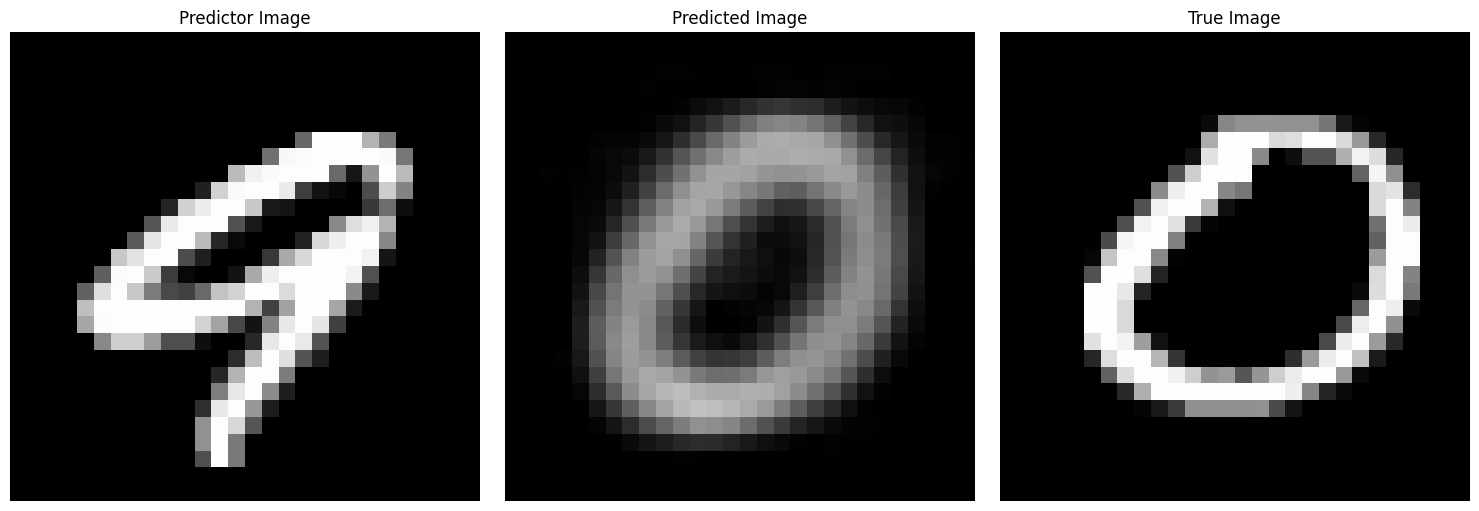

In [8]:
#make prediction plot as before, but with trained model
rand_test_idx = np.random.randint(len(test_ds))
i = rand_test_idx
X, y = test_ds[i]
X_gpu = torch.from_numpy(X).to(device)
with torch.no_grad():
    pred = model(X_gpu)
    pred = pred.cpu().numpy()
plot_num2num_prediction(X, y, pred)

## Impact of Fuzziness on Autoregressive Rollout
With our simple, densely-connected NN architecture, the fuzziness causes instability in an autoregressive rollout (feeding model output back into itself). Particularly, the fuzzy 1s, 5s, and 3s are confused for 8s, and the model gets caught osillating between 9s and 0ish output.

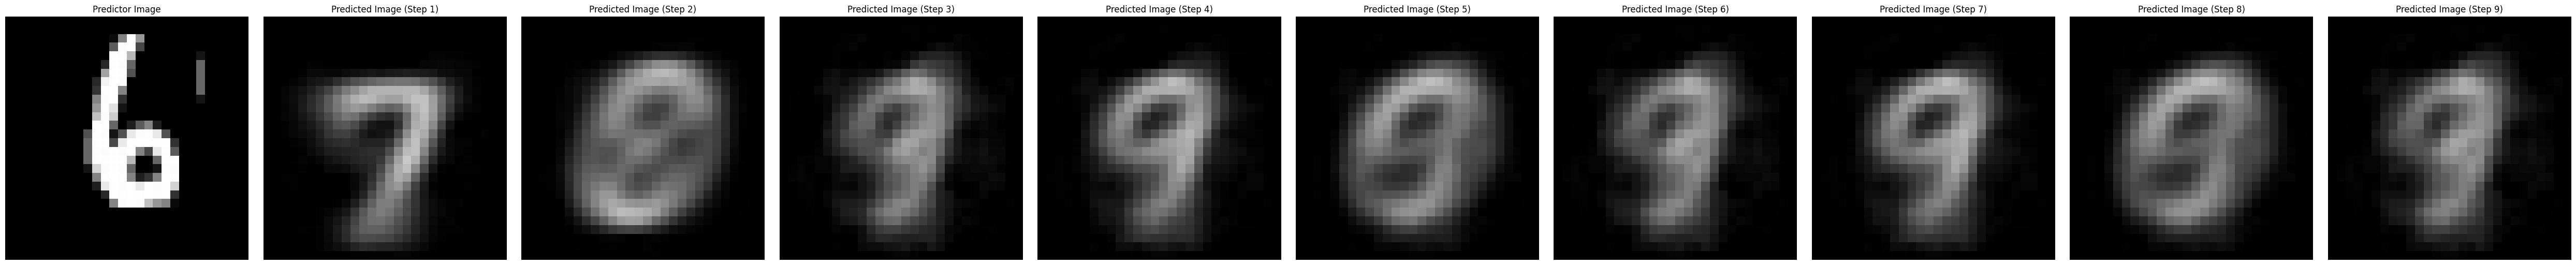

In [9]:
def plot_autoregressive_sequence(X, model, n_steps=3):
    """
    Plots the progression from the original predictor image through n autoregressive steps.
    :param X: numpy array - Original predictor image
    :param model: torch.nn.Module - Trained model for predictions
    :param n_steps: int - Number of autoregressive steps to take
    """
    device = next(model.parameters()).device 
    X_gpu = torch.from_numpy(X).to(device)

    predictions = [X] 
    current_input = X_gpu

    with torch.no_grad():
        for _ in range(n_steps):
            pred = model(current_input)  
            pred_np = pred.cpu().numpy()  
            predictions.append(pred_np) 
            current_input = torch.from_numpy(pred_np).to(device)  # Use prediction as new input

    # Create dynamic plotting layout
    n_cols = n_steps + 1  # Predictor + n steps + True image
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 5))

    # Plot predictor image
    axes[0].imshow(X.squeeze(), cmap="gray", vmin=0., vmax=1.)
    axes[0].set_title("Predictor Image")
    axes[0].axis("off")

    # Plot each autoregressive step
    for i in range(1, n_steps + 1):
        axes[i].imshow(predictions[i].squeeze(), cmap="gray", vmin=0., vmax=1.)
        axes[i].set_title(f"Predicted Image (Step {i})")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Select a random test sample
rand_test_idx = np.random.randint(len(test_ds))
X, y = test_ds[rand_test_idx]

# Call function with n autoregressive steps
plot_autoregressive_sequence(X, model, n_steps=9)
